### Imputación de datos faltantes

Imputa las temperaturas faltantes por diferentes métodos:
- simple (lineal)
- por tiempo
- polinómica de grado 2
- BiLSTM

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [85]:
# después de imputar, completo las otras columnas, que dependen de las primeras.
# clip de outliers (opcional)
def set_mes_delta(df, clip=True, pmin=0.005, pmax=0.995):

    df['mes'] = df['fecha'].dt.month
    df['delta'] = df['estepa']- df['pino']

    if clip:
        pmin_delta = df['delta'].quantile(pmin)
        pmax_delta = df['delta'].quantile(pmax)
        df['delta'] = df['delta'].clip(lower=pmin_delta, upper=pmax_delta)


In [120]:
# plot de delta con línea de valores extremos
def plot_delta(df, titulo='', pmin=0.005, pmax=0.995):
    fig, axs = plt.subplots(1, 1, figsize=(14, 4))

    pmin_delta = df['delta'].quantile(pmin)
    pmax_delta = df['delta'].quantile(pmax)
        
    plt.bar(df['fecha'], df['delta'])
    # Línea horizontal en los percentiles extremos
    plt.axhline(y=pmin_delta, linestyle='--', linewidth=1, color='red', label=f'{pmin} ({pmin_delta:.2f})')
    plt.axhline(y=pmax_delta, linestyle='--', linewidth=1, color='red', label=f'{pmax} ({pmax_delta:.2f})')
    plt.title(titulo)
    plt.grid(axis='y')
    plt.legend()
    plt.show()  


#### Lee las temperaturas diurnas x día

In [87]:
# Temperaturas diurnas (diarias)
df_dia = pd.read_csv("csv/ts_d_diario.csv", parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })
df_dia.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,NaN,17.944593,1,NaN
5,2020-01-06,NaN,NaN,1,NaN
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,NaN,NaN,1,NaN
8,2020-01-09,NaN,NaN,1,NaN
9,2020-01-10,27.450967,22.472114,1,4.978853


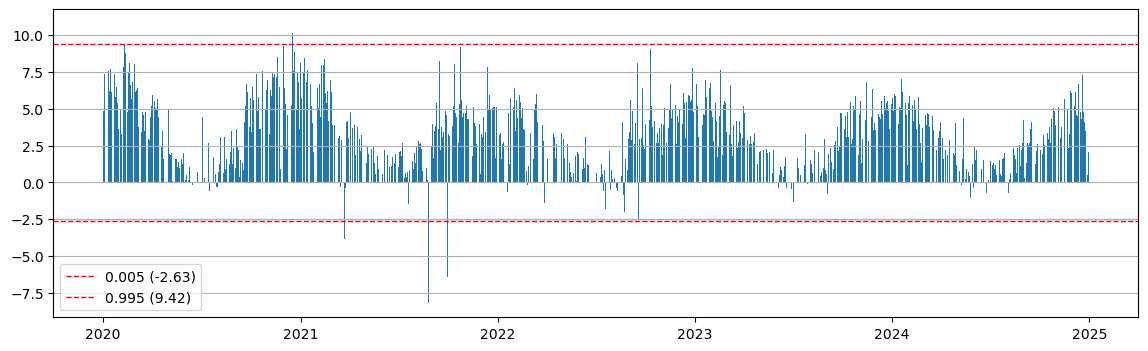

In [121]:
plot_delta(df_dia)

## Imputación simple

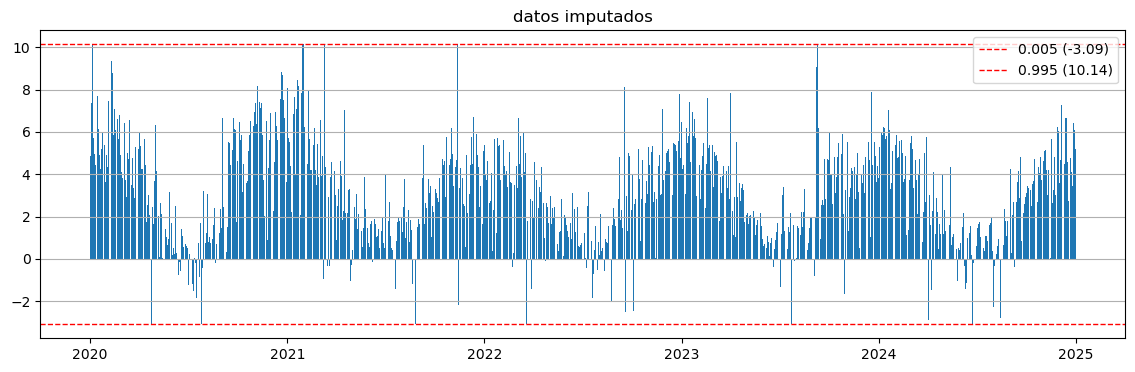

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,34.411211,17.944593,1,10.142057
5,2020-01-06,30.001096,18.733816,1,10.142057
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,26.210976,20.506064,1,5.704912
8,2020-01-09,26.830971,21.489089,1,5.341882
9,2020-01-10,27.450967,22.472114,1,4.978853


In [122]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='linear')
df_imputed['pino']   = df_imputed['pino'].interpolate(method='linear')
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed, clip=True, pmin=0.01)

plot_delta(df_imputed, 'datos imputados')

df_imputed.head(15)

In [90]:
# Exporta el resultado
salida = 'csv/ts_imputado_simple.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación por interpolación. Método 'time'

In [91]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='time')
df_imputed['pino']   = df_imputed['pino'].interpolate(method='time')
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed)
df_imputed.head(20)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,34.411211,17.944593,1,10.142057
5,2020-01-06,30.001096,18.733816,1,10.142057
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,26.210976,20.506064,1,5.704912
8,2020-01-09,26.830971,21.489089,1,5.341882
9,2020-01-10,27.450967,22.472114,1,4.978853


In [92]:
# Exporta el resultado
salida = 'csv/ts_imputado_time.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación por interpolación. Método polinómico

In [93]:
df_imputed = df_dia.copy()

df_imputed= df_imputed.set_index('fecha')
df_imputed['estepa'] = df_imputed['estepa'].interpolate(method='polynomial', order=2)
df_imputed['pino']   = df_imputed['pino'].interpolate(method='polynomial', order=2)
df_imputed = df_imputed.reset_index()

set_mes_delta(df_imputed)
df_imputed.head(15)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,37.634369,17.944593,1,10.565953
5,2020-01-06,31.017693,15.534118,1,10.565953
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,22.457512,20.567543,1,1.889969
8,2020-01-09,22.104028,19.628610,1,2.475419
9,2020-01-10,27.450967,22.472114,1,4.978853


In [94]:
# Exporta el resultado
salida = 'csv/ts_imputado_polinomio.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)

## Imputación con BiLSTM

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-12-08 13:22:01.566793: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [96]:
df = df_dia.copy()

In [97]:
cols_to_impute = ['estepa', 'pino']
data = df[cols_to_impute].copy()

#data['day_of_year'] = df['fecha'].dt.dayofyear
#data['sin_day'] = np.sin(2 * np.pi * data['day_of_year'] / 365.25)
#data['cos_day'] = np.cos(2 * np.pi * data['day_of_year'] / 365.25)
#data = data.drop('day_of_year', axis=1)

#data['semana_del_año'] = df['fecha'].dt.isocalendar().week
#data['sin_day'] = np.sin(2 * np.pi * data['semana_del_año'] / 52)
#data['cos_day'] = np.cos(2 * np.pi * data['semana_del_año'] / 52)
#data = data.drop('semana_del_año', axis=1)

data.head(10)

,estepa,pino
0,35.433453,33.666374
1,36.195872,31.342840
2,35.245773,31.284172
3,38.821326,31.450303
4,NaN,17.944593
5,NaN,NaN
6,25.590980,19.523039
7,NaN,NaN
8,NaN,NaN
9,27.450967,22.472114


In [98]:
# Parámetros
TEST_SIZE_FOR_MASK = 0.15        # 15 % de valores CONOCIDOS los borramos artificialmente para validar
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [99]:
# Máscara de valores REALMENTE faltantes + máscara de validación artificial

real_missing = data.isna().values                     # True donde faltan de verdad
known_values = ~real_missing                          # True donde SÍ tenemos valor real

# Borramos artificialmente un % de los valores que sí conocemos (para validar)
mask_val = np.random.random(data.shape) < TEST_SIZE_FOR_MASK
mask_val = mask_val & known_values                    # solo borramos donde había valor real

validation_missing = mask_val.copy()                  # estos los usaremos para medir error realista
train_missing = real_missing | validation_missing     # valores que el modelo NO verá en entrenamiento

# Serie que el modelo verá (con todos los gaps: reales + artificiales)
data_train = data.copy()
data_train.values[train_missing] = np.nan

In [100]:
# Relleno provisorio para poder entrenar (solo interpolación simple)
data_filled = data_train.interpolate(method='linear', limit_direction='both')
data_filled = data_filled.fillna(method='bfill').fillna(method='ffill')

In [101]:
# Normalización
scaler = StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_filled),
    index=data_filled.index,
    columns=data_filled.columns
)

In [102]:
# Preparamos tensores (una sola secuencia grande)
X_train = data_scaled.values.reshape(1, -1, 2)      # shape (1, n_timesteps, 2)
X_with_real_gaps = np.where(train_missing, 0, data_scaled.values)
X_with_real_gaps = X_with_real_gaps.reshape(1, -1, 2)
y_train = X_train[:, :, :2]    # solo estepa y pino

In [103]:
# Modelo BiLSTM multivariado

model = Sequential([
    Input(shape=(None, 2)),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True, recurrent_dropout=0.2)),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=True, recurrent_dropout=0.1)),
    TimeDistributed(Dense(2))
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, None, 256)      │       134,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 128)      │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 64)       │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 2)        │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,842 (1.30 MB)

 Trainable params: 339,842 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

# Entrena el modelo
history = model.fit(X_train, y_train, epochs=250, batch_size=1, 
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 72s 72s/step - loss: 0.7328
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.5030
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3536
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2141
Epoch 5/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1748
Epoch 6/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1454
Epoch 7/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1247
Epoch 8/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1528
Epoch 9/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1650
Epoch 10/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2068
Epoch 11/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1680
Epoch 12/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1540
Epoch 13/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1669
Epoch 14/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1548
Epoch 15/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1358
Epoch 16/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/ste

In [105]:
# Imputación final sobre los gaps reales + artificiales
pred_scaled = model.predict(X_with_real_gaps, verbose=0)[0]   # (n_timesteps, 2)
pred_original = scaler.inverse_transform(pred_scaled)[:, :2]   # las 2 primeras
pred_df = pd.DataFrame(pred_original, index=df.index, columns=cols_to_impute)

In [106]:
# Serie final imputada (solo sustituimos donde realmente faltaba el dato)
df_imputed = df.copy()
df_imputed[cols_to_impute] = df[cols_to_impute].fillna(pred_df[cols_to_impute])

In [107]:
# VALIDACIÓN ENMASCARADA

mae_por_columna = {}

if validation_missing.any():
    rows, cols = np.where(validation_missing)
    
    y_true = data.values[rows, cols]
    y_pred = pred_original[rows, cols]
    
    for col_idx, col_name in enumerate(cols_to_impute):
        mask_col = (cols == col_idx)
        if mask_col.any():
            true_col = y_true[mask_col]
            pred_col = y_pred[mask_col]
            mae = mean_absolute_error(true_col, pred_col)
            mae_por_columna[col_name] = mae
            print(f"  {col_name:6} MAE = {mae:.3f} °C  ({mask_col.sum()} valores)")

else:
    print("No hay valores ocultados artificialmente para validar")
    mae_por_columna = {col: np.nan for col in cols_to_impute}


  estepa MAE = 3.884 °C  (248 valores)
  pino   MAE = 3.432 °C  (226 valores)


In [108]:
Q1 = df[['estepa', 'pino']].quantile(0.25)
Q3 = df[['estepa', 'pino']].quantile(0.75)
IQR = Q3 - Q1

MAE_relativo_pino = mae_por_columna["pino"] / IQR["pino"] * 100
MAE_relativo_estepa = mae_por_columna["estepa"] / IQR["estepa"] * 100

print(f'\nPino  : MAE = {mae_por_columna["pino"]:.3f} °C  IQR {IQR["pino"]:.4f}  MAE relativo (%): {MAE_relativo_pino:.2f}')
print(f'Estepa: MAE = {mae_por_columna["estepa"]:.3f} °C  IQR {IQR["estepa"]:.4f}  MAE relativo (%): {MAE_relativo_estepa:.2f}\n')


Pino  : MAE = 3.432 °C  IQR 19.9034  MAE relativo (%): 17.24
Estepa: MAE = 3.884 °C  IQR 23.0537  MAE relativo (%): 16.85




Pino  : MAE = 4.398 °C  IQR 19.9034  MAE relativo (%): 22.09
Estepa: MAE = 4.933 °C  IQR 23.0537  MAE relativo (%): 21.40

Pino  : MAE = 4.060 °C  IQR 19.9034  MAE relativo (%): 20.40
Estepa: MAE = 4.112 °C  IQR 23.0537  MAE relativo (%): 17.84

### Resultado

Recomputo las columnas faltantes y exporto los resultados para usarlos en los modelos predictivos.

In [109]:
# recalculo las columnas mes y delta
df_imputed = df_imputed.reset_index()
set_mes_delta(df_imputed)
df_imputed.head(15)

,index,fecha,estepa,pino,mes,delta
0,0,2020-01-01,35.433453,33.666374,1,1.767079
1,1,2020-01-02,36.195872,31.342840,1,4.853032
2,2,2020-01-03,35.245773,31.284172,1,3.961601
3,3,2020-01-04,38.821326,31.450303,1,7.371023
4,4,2020-01-05,27.833326,17.944593,1,9.854970
5,5,2020-01-06,28.426195,24.857557,1,3.568638
6,6,2020-01-07,25.590980,19.523039,1,6.067942
7,7,2020-01-08,29.440401,25.803408,1,3.636993
8,8,2020-01-09,29.890858,26.242332,1,3.648525
9,9,2020-01-10,27.450967,22.472114,1,4.978853


In [110]:
# Exporta el resultado
salida = 'csv/ts_imputado_bilstm.csv'
df_imputed[['fecha','estepa','pino','mes','delta']].to_csv(salida, index=False)